# Thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.express as px
import inspect
import time
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_data.csv")
df["timestamp_local"] = pd.to_datetime(df["timestamp_local"])
df.set_index("timestamp_local", inplace=True)
df.head()

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos
timestamp_local,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,152.0,432.8,57.3,22.3,83.3,56.67,37.7,22.0,83.0,1015.0,1.0,320.0,100.0,0.25,0,19.0,-0.64,0.77
2023-01-01 01:00:00,150.0,402.1,54.0,20.0,79.0,54.00,32.0,22.0,83.0,1014.0,2.1,330.0,99.0,0.00,0,19.0,-0.50,0.87
2023-01-01 02:00:00,134.0,361.2,45.3,24.3,70.3,48.00,31.7,22.0,83.0,1013.0,2.1,330.0,100.0,0.00,0,19.0,-0.50,0.87
2023-01-01 03:00:00,118.0,320.4,36.7,28.7,61.7,42.00,31.3,22.0,83.0,1013.0,2.1,335.0,100.0,0.00,0,19.0,-0.42,0.91
2023-01-01 04:00:00,102.0,279.5,28.0,33.0,53.0,36.00,31.0,22.0,78.0,1013.0,2.1,330.0,100.0,0.00,0,18.0,-0.50,0.87


In [3]:
df_pm25_hourly = df[["pm25"]].copy()
df_pm25_daily = df_pm25_hourly.resample("d")["pm25"].agg("mean")
df_pm25 = df_pm25_daily
df_pm25

timestamp_local
2023-01-01    25.583333
2023-01-02    25.291667
2023-01-03    23.833333
2023-01-04    22.777917
2023-01-05    11.055417
                ...    
2025-11-27    12.750000
2025-11-28     7.417083
2025-11-29    16.773333
2025-11-30     8.680417
2025-12-01    10.000000
Freq: D, Name: pm25, Length: 1066, dtype: float64

In [4]:
df_pm25.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1066 entries, 2023-01-01 to 2025-12-01
Freq: D
Series name: pm25
Non-Null Count  Dtype  
--------------  -----  
1066 non-null   float64
dtypes: float64(1)
memory usage: 16.7 KB


In [5]:
adf_result = adfuller(df_pm25)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -3.1561931732882886
p-value: 0.022664592780271938
Critical Values: {'1%': np.float64(-3.4365991650067502), '5%': np.float64(-2.864299173128419), '10%': np.float64(-2.5682390922672735)}


<Axes: title={'center': 'Daily PM2.5 Levels'}, xlabel='Date', ylabel='PM2.5'>

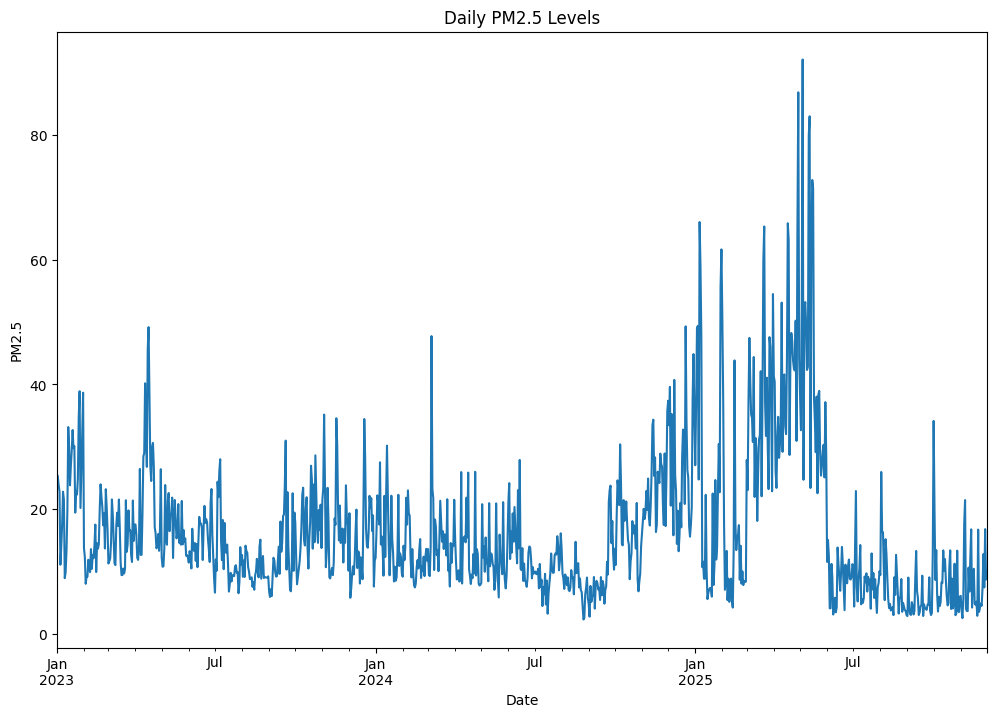

In [6]:
fig,ax = plt.subplots(figsize=(12,8))
df_pm25.plot(xlabel='Date', ylabel='PM2.5', title='Daily PM2.5 Levels', ax=ax)


Text(0.5, 1.0, 'Autocorrelation Function (ACF) for Daily PM2.5')

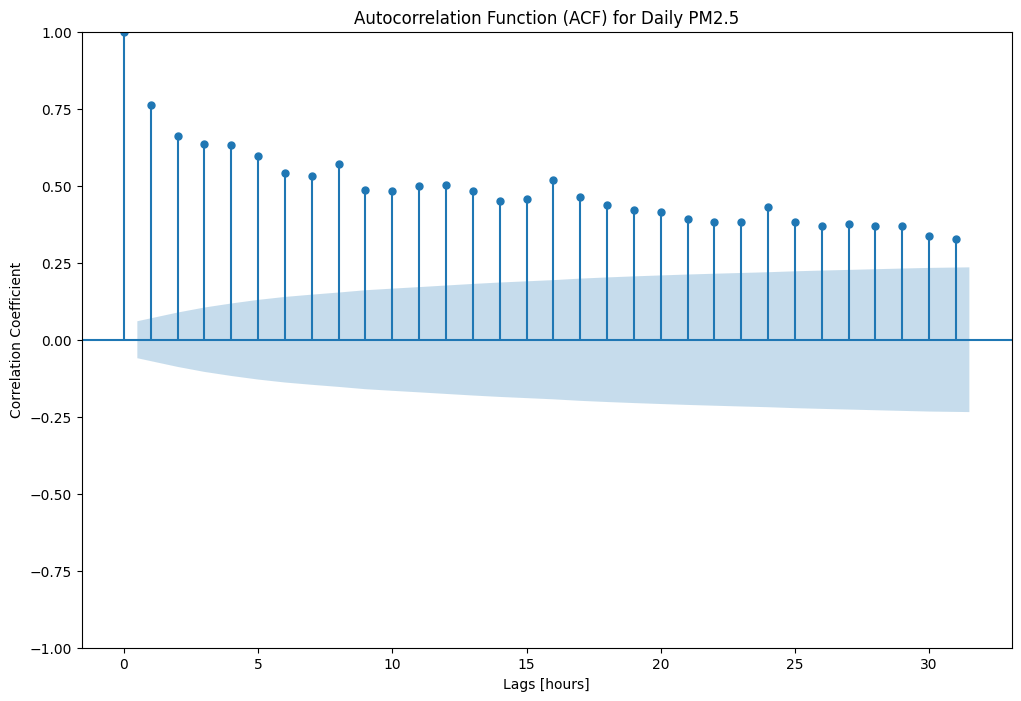

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
plot_acf(df_pm25, ax=ax)
plt.xlabel('Lags [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation Function (ACF) for Daily PM2.5')

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Daily PM2.5')

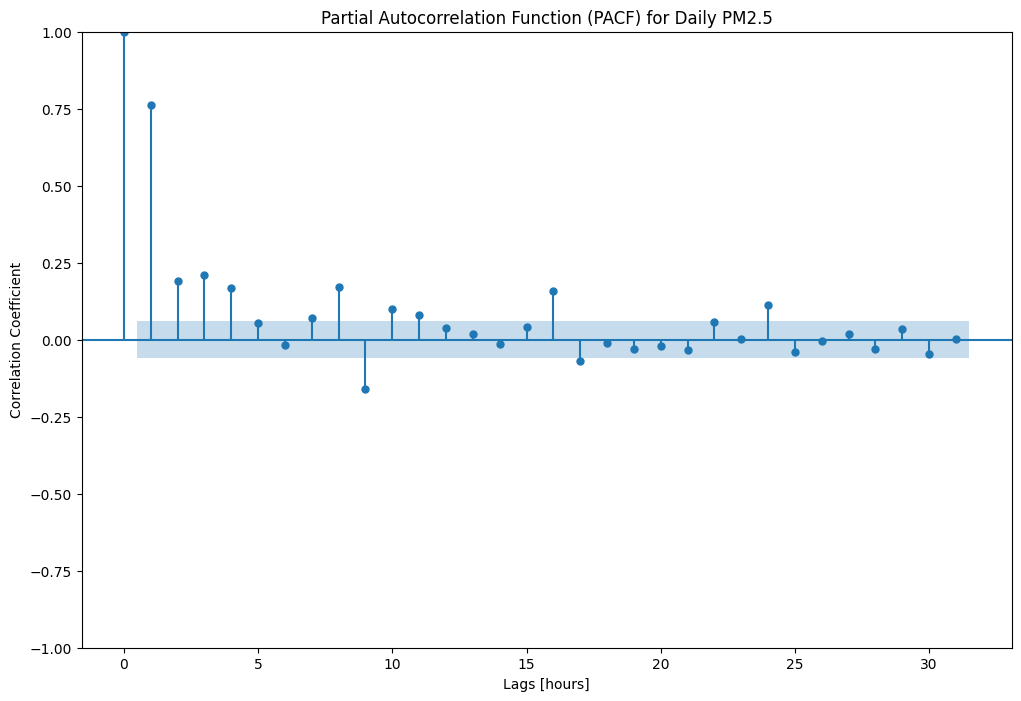

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
plot_pacf(df_pm25, ax=ax)
plt.xlabel('Lags [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Partial Autocorrelation Function (PACF) for Daily PM2.5')

In [10]:
int(len(df_pm25)) *0.8

852.8000000000001

In [12]:
cutoff_test = int(len(df_pm25)* 0.8) 
df_pm25_train = df_pm25.iloc[:cutoff_test]
df_pm25_test = df_pm25.iloc[cutoff_test:]
print("df_pm25_train shape:", df_pm25_train.shape)
print("df_pm25_test shape:", df_pm25_test.shape)

df_pm25_train shape: (852,)
df_pm25_test shape: (214,)


In [13]:
# Perform ADF test
adf_result = adfuller(df_pm25_train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -2.0661726666147255
p-value: 0.2583324131621705
Critical Values: {'1%': np.float64(-3.4382057088878644), '5%': np.float64(-2.865007578546518), '10%': np.float64(-2.5686164240381513)}


In [14]:
df_pm25_train_mean = df_pm25_train.mean()
df_pm25_pred_baseline = [df_pm25_train_mean]*len(df_pm25_train)
mae_baseline = mean_absolute_error(df_pm25_train, df_pm25_pred_baseline)

print("Mean P2 Reading:", round(df_pm25_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 17.46
Baseline MAE: 7.8


In [15]:
p_params = range(0, 8, 1)
q_params = range(0, 3, 1)
list(p_params)

[0, 1, 2, 3, 4, 5, 6, 7]

In [16]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 1, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(df_pm25_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        df_pm25_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(df_pm25_train, df_pm25_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 1, 0) in 0.05 seconds.
Trained ARIMA (0, 1, 1) in 0.05 seconds.
Trained ARIMA (0, 1, 2) in 0.06 seconds.
Trained ARIMA (1, 1, 0) in 0.03 seconds.
Trained ARIMA (1, 1, 1) in 0.06 seconds.
Trained ARIMA (1, 1, 2) in 0.12 seconds.
Trained ARIMA (2, 1, 0) in 0.05 seconds.
Trained ARIMA (2, 1, 1) in 0.1 seconds.
Trained ARIMA (2, 1, 2) in 0.23 seconds.
Trained ARIMA (3, 1, 0) in 0.08 seconds.
Trained ARIMA (3, 1, 1) in 0.19 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (3, 1, 2) in 0.44 seconds.
Trained ARIMA (4, 1, 0) in 0.09 seconds.
Trained ARIMA (4, 1, 1) in 0.24 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (4, 1, 2) in 0.47 seconds.
Trained ARIMA (5, 1, 0) in 0.13 seconds.
Trained ARIMA (5, 1, 1) in 0.34 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (5, 1, 2) in 0.58 seconds.
Trained ARIMA (6, 1, 0) in 0.14 seconds.
Trained ARIMA (6, 1, 1) in 0.42 seconds.
Trained ARIMA (6, 1, 2) in 0.76 seconds.
Trained ARIMA (7, 1, 0) in 0.19 seconds.
Trained ARIMA (7, 1, 1) in 0.43 seconds.
Trained ARIMA (7, 1, 2) in 0.9 seconds.

{0: [5.097084800469486, 4.795316614795763, 4.7897975579997265], 1: [4.9266939917310735, 4.732064292062559, 4.721298683490879], 2: [4.852978563612138, 4.724180871798104, 4.70003693109076], 3: [4.778894913879297, 4.717264240928957, 4.699198541178953], 4: [4.773017324815266, 4.710447142259535, 4.687443754300816], 5: [4.760171105398105, 4.7129790387456545, 4.685760881725966], 6: [4.770074183969791, 4.7126157047470105, 4.6861361593859385], 7: [4.70893936165043, 4.702810485134045, 4.6804264739227035]}


In [17]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5,6,7
0,5.0971,4.9267,4.8530,4.7789,4.7730,4.7602,4.7701,4.7089
1,4.7953,4.7321,4.7242,4.7173,4.7104,4.7130,4.7126,4.7028
2,4.7898,4.7213,4.7000,4.6992,4.6874,4.6858,4.6861,4.6804


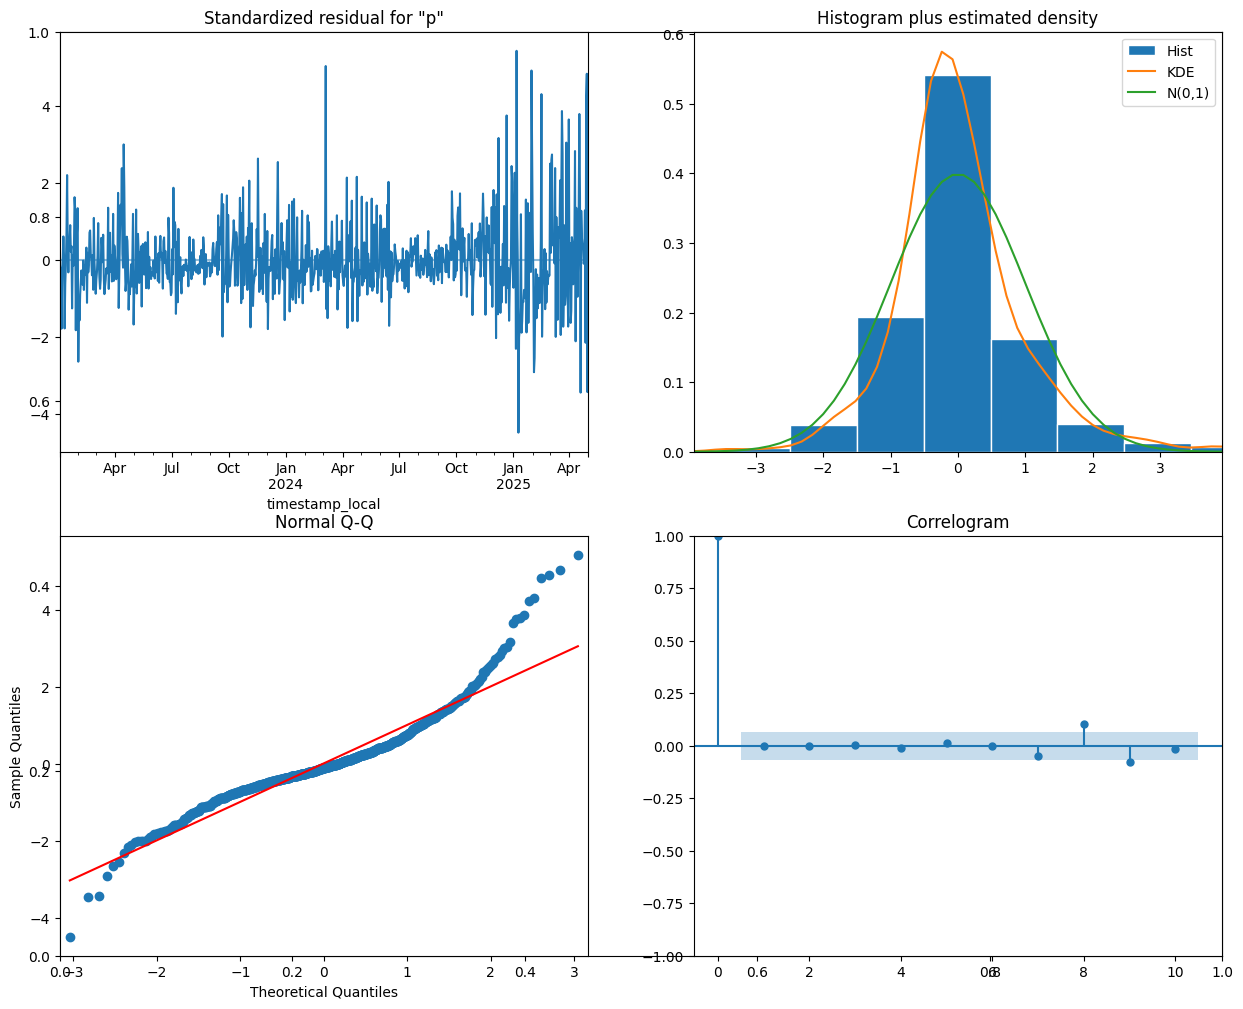

In [18]:
model = ARIMA(df_pm25_train, order=(5,1,1))
results = model.fit()
fig, ax = plt.subplots(figsize=(15, 12))
results.plot_diagnostics(fig=fig)
# Save the plot as an image file (e.g., PNG)
plt.savefig('example_plot.png')

In [19]:
df_pm25_pred_wfv = pd.Series()  # Initialize as an empty Series instead of a list
history = df_pm25_train.copy()
for i in range(len(df_pm25_test)):
    model = ARIMA(history, order = (5, 1, 1)).fit()
    next_pred = model.forecast()
    df_pm25_pred_wfv = pd.concat([df_pm25_pred_wfv, pd.Series(next_pred)])
    # Round the entire Series to 2 decimals
    df_pm25_pred_wfv = df_pm25_pred_wfv.round(2)
    history = pd.concat([history, df_pm25_test[next_pred.index]])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5648\1733131424.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_pm25_pred_wfv = pd.concat([df_pm25_pred_wfv, pd.Series(next_pred)])


In [20]:
df_pm25_pred_wfv

2025-05-02    44.62
2025-05-03    39.66
2025-05-04    46.19
2025-05-05    70.93
2025-05-06    34.23
              ...  
2025-11-27     6.68
2025-11-28     9.61
2025-11-29     7.19
2025-11-30    12.76
2025-12-01     9.04
Freq: D, Length: 214, dtype: float64

In [21]:
test_mae = mean_absolute_error(df_pm25_test, df_pm25_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 5.28


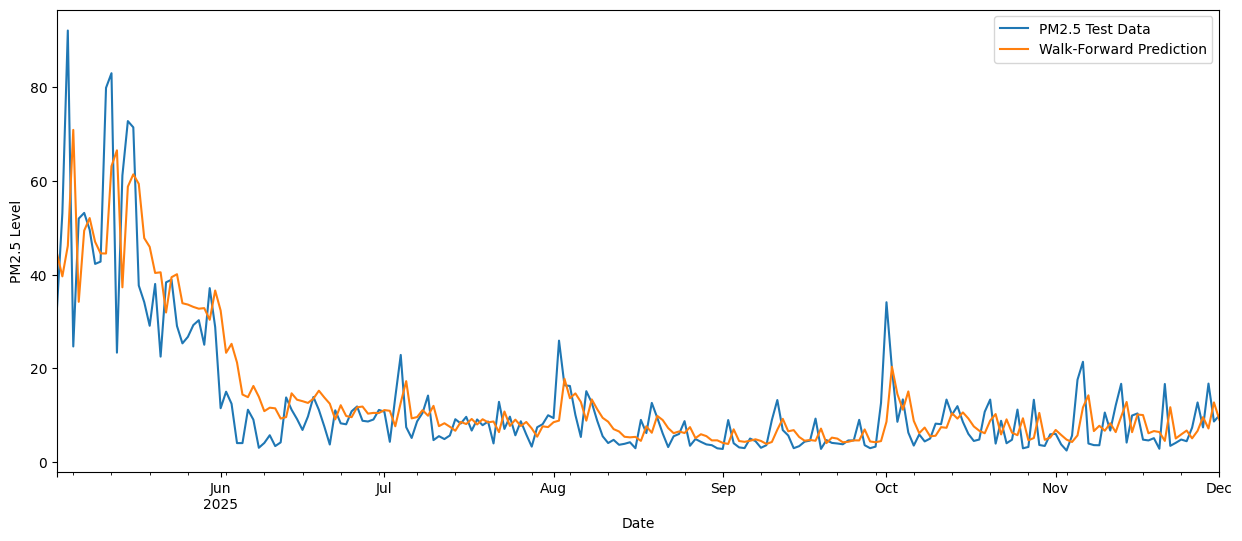

In [22]:
ax = df_pm25_test.plot(label = 'PM2.5 Test Data', figsize=(15, 6))
df_pm25_pred_wfv.plot(ax=ax, label='Walk-Forward Prediction')
plt.ylabel('PM2.5 Level')
plt.xlabel('Date')
plt.legend()
plt.show()

# BÁO CÁO ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH DỰ BÁO CHẤT LƯỢNG KHÔNG KHÍ (WALK-FORWARD VALIDATION)

**Ngày báo cáo:** 05/01/2026
**Đối tượng đánh giá:** Mô hình dự báo chuỗi thời gian (Time-series Forecasting Model) cho chỉ số PM2.5.
**Dữ liệu kiểm thử:** Từ tháng 05/2025 đến tháng 12/2025.

---

## 1. Nhận xét tổng quan (General Verdict)
**Đánh giá chung: MÔ HÌNH Ở MỨC KHÁ TỐT (ACCEPTABLE / GOOD FIT).**

Mô hình đã thể hiện khả năng nắm bắt **xu hướng (trend)** và **tính mùa vụ (seasonality)** của dữ liệu rất tốt. Đường màu cam (Prediction) bám sát đường màu xanh (Test Data) trong phần lớn thời gian, đặc biệt là trong các giai đoạn chỉ số PM2.5 ổn định.

Tuy nhiên, mô hình vẫn còn hạn chế trong việc dự báo các **điểm cực trị (extreme values)** và có hiện tượng trễ pha nhẹ.

## 2. Phân tích chi tiết từng giai đoạn

### 2.1. Giai đoạn biến động mạnh (Tháng 5/2025)
* **Đặc điểm:** Đây là giai đoạn chuyển mùa (có thể từ khô sang mưa), PM2.5 dao động rất mạnh với biên độ lớn (từ 20 lên 90).
* **Hiệu suất:** Mô hình gặp khó khăn nhất ở giai đoạn này.
    * **Under-prediction (Dự báo thấp hơn thực tế):** Tại các đỉnh nhọn (peaks) cao nhất (~90), mô hình chỉ dự báo được khoảng ~60-70. Điều này có nghĩa là hệ thống cảnh báo có thể sẽ bỏ sót các đợt ô nhiễm cấp tính nghiêm trọng.
    * **Lag (Độ trễ):** Đường màu cam có xu hướng đi sau đường màu xanh khoảng 1 bước thời gian (one-step lag), cho thấy mô hình đang phụ thuộc nhiều vào giá trị quá khứ gần nhất ($t-1$) hơn là nắm bắt được các biến số ngoại sinh (như gió, mưa) để dự báo sớm.

### 2.2. Giai đoạn ổn định (Tháng 6 - Tháng 9/2025)
* **Đặc điểm:** Đây trùng khớp với **mùa mưa** tại Cần Thơ (như đã phân tích ở biểu đồ mưa trước đó). Nồng độ PM2.5 thấp và ít biến động (dao động quanh mức 5-15).
* **Hiệu suất:** **Rất tốt.**
    * Đường dự báo gần như trùng khít với dữ liệu thực tế.
    * Sai số (Residuals) ở giai đoạn này rất nhỏ.
    * Mô hình nhận diện chính xác xu hướng giảm sâu của PM2.5 do tác động rửa trôi của mưa.

### 2.3. Giai đoạn cuối năm (Tháng 10 - Tháng 12/2025)
* **Đặc điểm:** PM2.5 bắt đầu có xu hướng tăng nhẹ trở lại và xuất hiện các đợt biến động nhỏ (có thể do bắt đầu vào mùa khô, gió chướng hoạt động).
* **Hiệu suất:** Khá ổn định. Mô hình bắt được nhịp tăng giảm, nhưng vẫn lặp lại lỗi không bắt được đỉnh nhọn (ví dụ: đỉnh nhọn vào đầu tháng 10).

## 3. Các vấn đề tồn tại và rủi ro

1.  **Làm mịn quá mức (Over-smoothing):**
    Mô hình có xu hướng "trung bình hóa" các biến động. Nó không dám đưa ra các dự báo tăng vọt hoặc giảm sâu đột ngột như thực tế. Điều này an toàn cho các chỉ số thống kê (như RMSE) nhưng lại **kém hiệu quả cho bài toán Cảnh báo sớm (Early Warning)**.

2.  **Độ trễ (Lagging):**
    Nhìn kỹ các đỉnh, đường màu cam thường đạt đỉnh trễ hơn đường màu xanh một chút. Trong thực tế, điều này có nghĩa là: *"Ô nhiễm đã xảy ra rồi thì mô hình mới báo"*.

## 4. Kết luận và Khuyến nghị cải thiện

**Kết luận:**
Mô hình này **ĐÃ ỔN** để sử dụng cho mục đích theo dõi xu hướng chung và báo cáo thống kê trung bình ngày/tuần. Tuy nhiên, **CHƯA TỐI ƯU** để làm hệ thống cảnh báo tức thời (Real-time Alert System) cho các sự kiện ô nhiễm cực đoan.

**Khuyến nghị kỹ thuật:**
1.  **Tích hợp thêm biến ngoại sinh (Exogenous Variables):**
    Nếu mô hình hiện tại chỉ là ARIMA hoặc LSTM đơn biến, hãy chắc chắn rằng bạn đã đưa các đặc trưng **Mưa (Precipitation)** và **Gió (Wind Speed)** (từ các biểu đồ trước) vào làm đầu vào. Mưa và Gió là 2 yếu tố "dọn dẹp" ô nhiễm, việc đưa chúng vào sẽ giúp mô hình dự đoán được các cú sụt giảm PM2.5 chính xác hơn.
2.  **Điều chỉnh hàm mất mát (Loss Function):**
    Nếu mục tiêu là bắt được các đỉnh ô nhiễm cao (để cảnh báo sức khỏe), hãy sử dụng các hàm loss phạt nặng hơn vào các sai số ở giá trị cao (ví dụ: Weighted MSE), thay vì MSE thông thường.
3.  **Khắc phục độ trễ:**
    Thử nghiệm các mô hình dạng **Hybrid** (kết hợp chuỗi thời gian tuyến tính và Machine Learning phi tuyến tính như XGBoost/Random Forest) để bắt các điểm gãy (turning points) tốt hơn.